In [1]:
# prelude
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from pathlib import Path
k_Current_dir = Path.cwd()
k_AssetsDir = "assets"
k_sms_max_len = 100

c:\Users\phili\anaconda3\envs\att\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------------------------------------------------------
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "labels"}, inplace=True)
    df.rename(columns={"v2": "texts"}, inplace=True)

    df["labels"] = df["labels"].map({"ham": 0, "spam": 1})

    return df

In [3]:
# -----------------------------------------------------------------------------
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [4]:
# -----------------------------------------------------------------------------
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
df = cleaner(df)
labels = df['labels'].tolist()
texts = df['texts'].tolist()

# BERT use multiple inputs (input_ids & attention_mask)
# We cannot use model = tf.keras.Sequential([...])

# define both inputs 
# input_ids = id of the token as defined in the pre-trainned model 
# Attention_masks are used to indicate which parts of the sequence should be taken into account by the model
# "Hello, how are you?"
# [7592, 1010, 2129, 2024, 2017, 1029]        input_ids
# [7592, 1010, 2129, 2024, 2017, 1029, 0, 0]  input_ids with padding
# [   1,    1,    1,    1,    1,    1, 0, 0]  attention_masks with padding
input_ids       = Input(shape=(k_sms_max_len,), dtype=tf.int32, name="input_ids")
attention_masks = Input(shape=(k_sms_max_len,), dtype=tf.int32, name="attention_mask")

# Load pretrained model & extracts embeddings
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
embeddings = bert_model(input_ids, attention_mask=attention_masks)[0]

# Get the CLS token from embeddings
cls_token = embeddings[:, 0, :]

# Add a dense layer with sigmoid activation
output = Dense(1, activation='sigmoid')(cls_token)

# Define the model
model = Model(inputs=[input_ids, attention_masks], outputs=output)

model.summary()

path = Path(f"{k_Current_dir/k_AssetsDir/'bert_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

# encode sms with BERT tokenizer 
# TODO : make a test with bert-base-uncased then bert-base-cased and compare
# uncased : all tokens in lowercase
# cased   : the model take the case into account
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
encoded_data = tokenizer(
    texts,
    max_length=k_sms_max_len,
    padding='max_length',       # sequences will be padded according the value of the parameter max_length
    truncation=True,
    return_tensors='tf'
)

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    encoded_data['input_ids'].numpy(), 
    encoded_data['attention_mask'].numpy(), 
    labels, 
    test_size=0.2, 
    random_state=42
)

# convert the datasets into tensors
X_train_ids     = tf.convert_to_tensor(X_train_ids)
X_test_ids      = tf.convert_to_tensor(X_test_ids)
X_train_mask    = tf.convert_to_tensor(X_train_mask)
X_test_mask     = tf.convert_to_tensor(X_test_mask)
y_train         = tf.convert_to_tensor(y_train)
y_test          = tf.convert_to_tensor(y_test)

# Gather encoded data into dictionaries for training
X_train = {'input_ids': X_train_ids, 'attention_mask': X_train_mask}
X_test = {'input_ids': X_test_ids, 'attention_mask': X_test_mask}

early_stopping = EarlyStopping(
    monitor='val_loss',           # can be 'val_accuracy' if needed 
    patience=3,          
    restore_best_weights=True  
)

# Reduces the learning rate when it stops improving
# helps to converge more quickly to a minimum
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,       # reduction factor of learning rate
    patience=2,       
    min_lr=1e-7       # minimal value for learning rate
)

path = Path(f"{k_Current_dir/k_AssetsDir/'bert_best_model.h5'}")
checkpoint = ModelCheckpoint(
    path,                       # model's path
    monitor='val_loss', 
    save_best_only=True, 
    mode='min'
)

tensorboard = TensorBoard(log_dir='logs', histogram_freq=1)
print(f"\n\n--------------------------------------------------")
print(f"Once the model runs, open a terminal, make sure you are in the directory of the project and type in : ")
print(f"tensorboard --logdir=logs")
print(f"Then visit the URL")

model.compile(
    optimizer=Adam(learning_rate=3e-5), 
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"],       # name=... avoid recall_1 for example
)

history = model.fit(
    [X_train['input_ids'], X_train['attention_mask']],
    y_train,
    validation_data=([X_test['input_ids'], X_test['attention_mask']], y_test),
    batch_size = 32,
    epochs = 50,
    callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard]  
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

c:\Users\phili\anaconda3\envs\att\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\phili\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\phili\anaconda3\envs\att\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_do



--------------------------------------------------
Once the model runs, open a terminal and type in : 
tensorboard --logdir=logs
Then visit the URL
Epoch 1/50
130/130 [==============================] - 1665s 13s/step - loss: 0.1546 - recall: 0.6280 - precision: 0.8243 - accuracy: 0.9378 - val_loss: 0.0744 - val_recall: 0.8621 - val_precision: 0.9766 - val_accuracy: 0.9778 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 1099s 8s/step - loss: 0.0620 - recall: 0.8937 - precision: 0.9518 - accuracy: 0.9814 - val_loss: 0.0474 - val_recall: 0.9241 - val_precision: 0.9781 - val_accuracy: 0.9865 - lr: 3.0000e-05
Epoch 3/50
130/130 [==============================] - 540s 4s/step - loss: 0.0324 - recall: 0.9449 - precision: 0.9796 - accuracy: 0.9908 - val_loss: 0.0424 - val_recall: 0.9379 - val_precision: 0.9784 - val_accuracy: 0.9884 - lr: 3.0000e-05
Epoch 4/50
130/130 [==============================] - 539s 4s/step - loss: 0.0167 - recall: 0.9626 - precision: 0.9899 - 

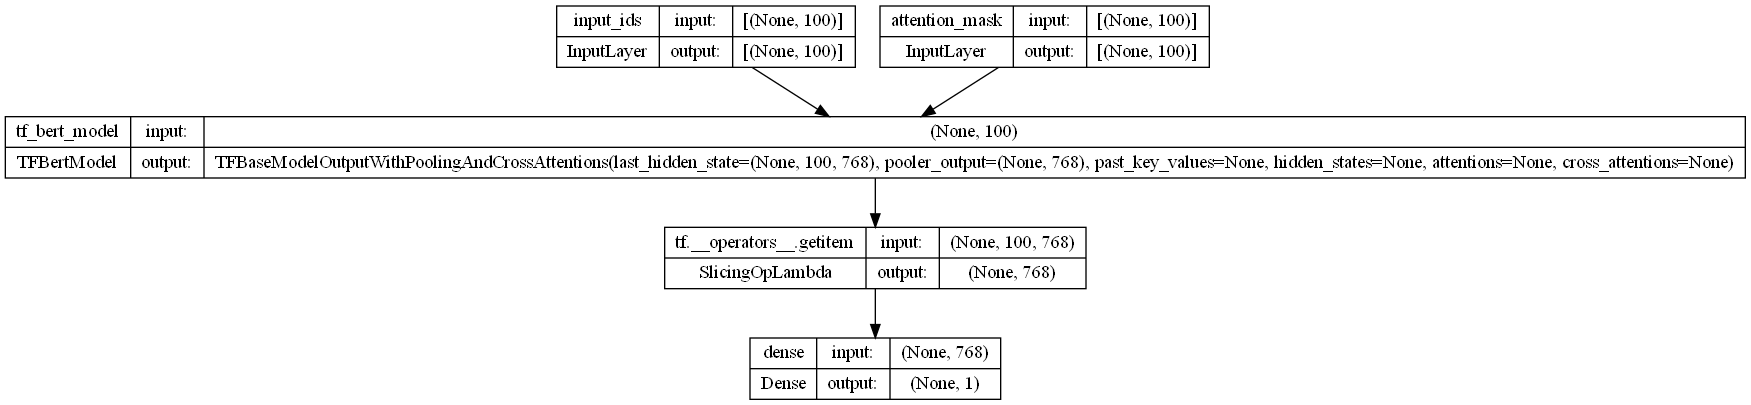

In [8]:
path = Path(f"{k_Current_dir/k_AssetsDir/'bert_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

Saving figure bert_loss


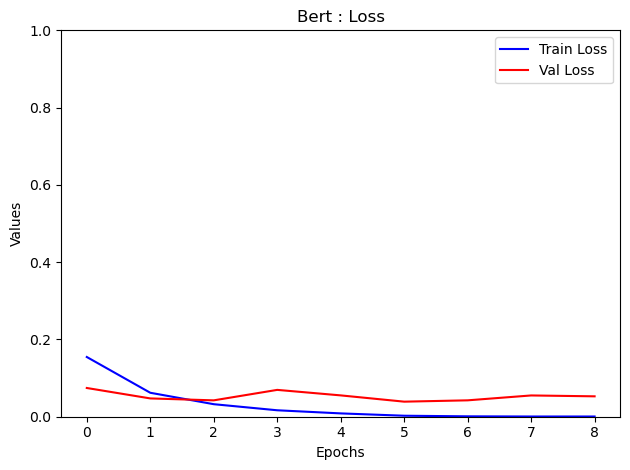

[[0.154587,
  0.062004,
  0.032425,
  0.016679,
  0.008607,
  0.002574,
  0.00102,
  0.000562,
  0.000562]]

[[0.074368,
  0.047361,
  0.042377,
  0.069465,
  0.055208,
  0.038981,
  0.042414,
  0.055051,
  0.052783]]

In [6]:
plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("bert_loss", "png")
plt.show()

display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])


Saving figure bert_accuracy


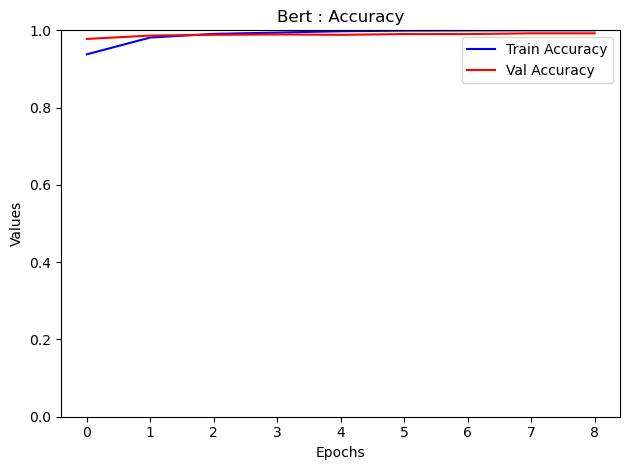

[[0.937848,
  0.981378,
  0.99081,
  0.994196,
  0.997582,
  0.999274,
  0.999758,
  1.0,
  1.0]]

[[0.977756,
  0.98646,
  0.988395,
  0.989362,
  0.988395,
  0.990329,
  0.990329,
  0.992263,
  0.992263]]

In [7]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Accuracy")
plt.legend()
plt.ylim(0,1)
save_fig("bert_accuracy", "png")
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])


Saving figure bert_precision


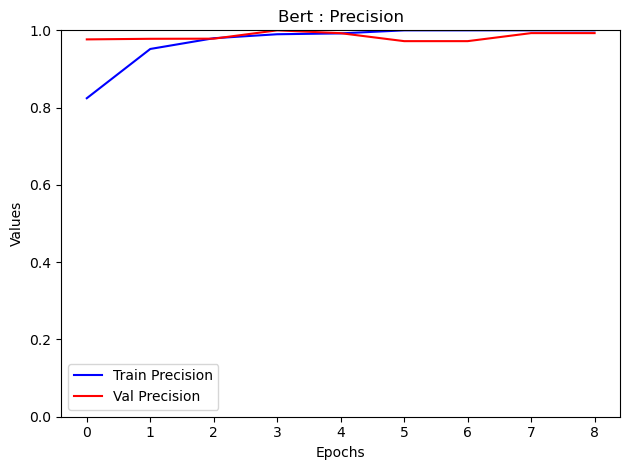

[[0.824289, 0.951782, 0.979592, 0.989879, 0.992095, 1.0, 1.0, 1.0, 1.0]]

[[0.976562,
  0.978102,
  0.978417,
  1.0,
  0.992593,
  0.972028,
  0.972028,
  0.992806,
  0.992806]]

In [9]:
plt.plot(history.history["precision"], color="b", label="Train Precision")
plt.plot(history.history["val_precision"], color="r", label="Val Precision")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Precision")
plt.legend()
plt.ylim(0,1)
save_fig("bert_precision", "png")
plt.show()

display([[round(f, 6) for f in history.history['precision'][-10:]]])
display([[round(f, 6) for f in history.history['val_precision'][-10:]]])

Saving figure bert_recall


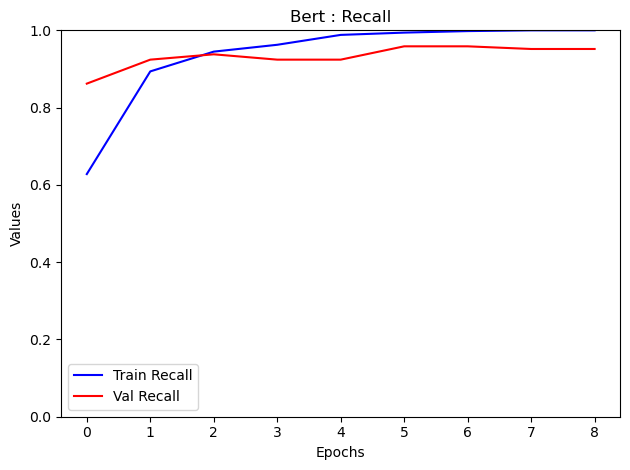

[[0.627953,
  0.893701,
  0.944882,
  0.962598,
  0.988189,
  0.994094,
  0.998031,
  1.0,
  1.0]]

[[0.862069,
  0.924138,
  0.937931,
  0.924138,
  0.924138,
  0.958621,
  0.958621,
  0.951724,
  0.951724]]

In [10]:
plt.plot(history.history["recall"], color="b", label="Train Recall")
plt.plot(history.history["val_recall"], color="r", label="Val Recall")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Recall")
plt.legend()
plt.ylim(0,1)
save_fig("bert_recall", "png")
plt.show()

display([[round(f, 6) for f in history.history['recall'][-10:]]])
display([[round(f, 6) for f in history.history['val_recall'][-10:]]])

In [11]:
def f1_calculus(name, rec, prec):
    df_tmp=pd.DataFrame()
    df_tmp[name] = 2*np.array(rec)*np.array(prec)/(np.array(rec)+np.array(prec)+tf.keras.backend.epsilon()) # epsilon avoid runtimeWarning: divide by zero encountered in divide...
    return df_tmp

Saving figure bert_f1


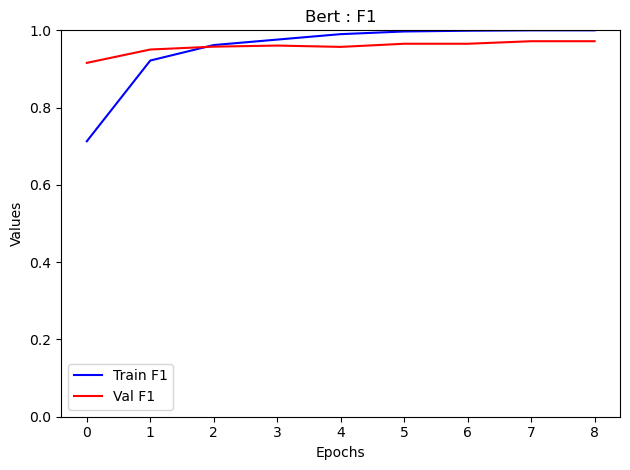

,f1
0,0.712849
1,0.921827
2,0.961924
3,0.976048
4,0.990138
5,0.997038
6,0.999015
7,1.000000
8,1.000000


,val_f1
0,0.915751
1,0.950355
2,0.957746
3,0.960573
4,0.957143
5,0.965278
6,0.965278
7,0.971831
8,0.971831


In [13]:
df_tmp = f1_calculus("f1", history.history["recall"], history.history["precision"])
df_val_tmp = f1_calculus("val_f1", history.history["val_recall"], history.history["val_precision"])

plt.plot(df_tmp["f1"], color="b", label="Train F1")
plt.plot(df_val_tmp["val_f1"], color="r", label="Val F1")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : F1")
plt.legend()
plt.ylim(0,1)
save_fig("bert_f1", "png")
plt.show()

display(df_tmp.tail(10))
display(df_val_tmp.tail(10))

### <span style="color:orange"><b>Comments :</b></span>

* Precision : 0.99 vs 0.98
* Recall    : 0.95 vs 0.89 
* F1        : 0.97 vs 0.93
* With `bert-base-uncased` we are able to keep the Precision while improving the Recall by 6% (& F1 by 4%)
* However 
    * the number of trainable parameters grows from 8_000 to 100 millions
    * the training time grows from 12 sec to 2H

 